Produktiv Version der Face-Verification

## Settings

In [1]:
from fastai2.data.external import untar_data,URLs
from fastai2.data.transforms import get_image_files
from fastai2.vision.all import *
import PIL

In [2]:
path = Path()
#img_path = path/"data/images/"
#files = get_image_files(img_path)
img_path = path/"google_face_images_dataset/"
files = get_image_files(img_path)

In [3]:
import re
def label_func(fname):
    #return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]
    return parent_label(fname)

In [4]:
# speed improved version to get all labels
# https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
import os
%time
list_subfolders = [f.path for f in os.scandir(img_path) if f.is_dir()]
len(list_subfolders)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


86282

In [5]:
m = re.match(r"^.*\/([^/]*)$", "data/images/00000637")
m.group(1)
re.match(r"^.*\/([^/]*)$", "data/images/00000637").group(1)

'00000637'

In [5]:
%%time
# lbl2files
# keys: str(foldername)
# values: Path objects
re_pattern = r"^.*\/([^/]*)$"
lbl2files2 = {str(re.match(re_pattern, l).group(1)): [Path(f.path) for f in os.scandir(l)] for l in list_subfolders}

CPU times: user 12.5 s, sys: 1.15 s, total: 13.6 s
Wall time: 13.6 s


In [6]:
labels = list(lbl2files2.keys())

In [7]:
assert len(lbl2files2.keys()) == len(lbl2files.keys())
keys_not_in_lbl2files2 = [key for key in lbl2files.keys() if key not in set(lbl2files2.keys())]
assert(len(keys_not_in_lbl2files2) == 0)

NameError: name 'lbl2files' is not defined

## Generate `lbl2files` From the Tutorial

In [88]:
%%time
labels = list(set(files.map(label_func)))

CPU times: user 155 ms, sys: 0 ns, total: 155 ms
Wall time: 154 ms


In [7]:
%%time
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

CPU times: user 1min 57s, sys: 0 ns, total: 1min 57s
Wall time: 1min 57s


## Do Some Checks

In [8]:
len(files), len(set(lbl2files2.keys()))

(2674176, 86282)

In [9]:
lbl2files = lbl2files2
#len(set(lbl2files.keys()))

In [10]:
empty_keys = [label for label in labels if len(lbl2files[label]) <= 0]
empty_keys    

['00080136']

In [11]:
for key in empty_keys:
    lbl2files.pop(key, None)
    labels.remove(key)

In [12]:
len(labels), len(list(lbl2files.keys()))

(86281, 86281)

In [13]:
empty_keys = [label for label in labels if len(lbl2files[label]) <= 0]
empty_keys

[]

In [13]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [14]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [15]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai2.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [16]:
encoder = create_body(resnet34, cut=-2)

In [17]:
head = create_head(512*4, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [18]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [19]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [20]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [21]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(t))
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(lbl2files[cls]),same

In [22]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(bs=64,
                      after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats), *aug_transforms()])    

In [23]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

In [24]:
learn.freeze()

SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=7.585775847473997e-07)

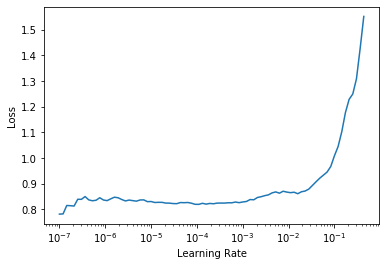

In [25]:
learn.lr_find()

In [107]:
(10e-3 + 10e-2 )/2

0.055

In [ ]:
learn.fit_one_cycle(5, 10e-4)

epoch,train_loss,valid_loss,accuracy,time


In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.229148,0.167584,0.937370,03:43


In [24]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        print("x[2]: ", x[2])
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

x[2]:  tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1])
x[2]:  tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1])
x[2]:  tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1])
x[2]:  tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1])
x[2]:  tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 

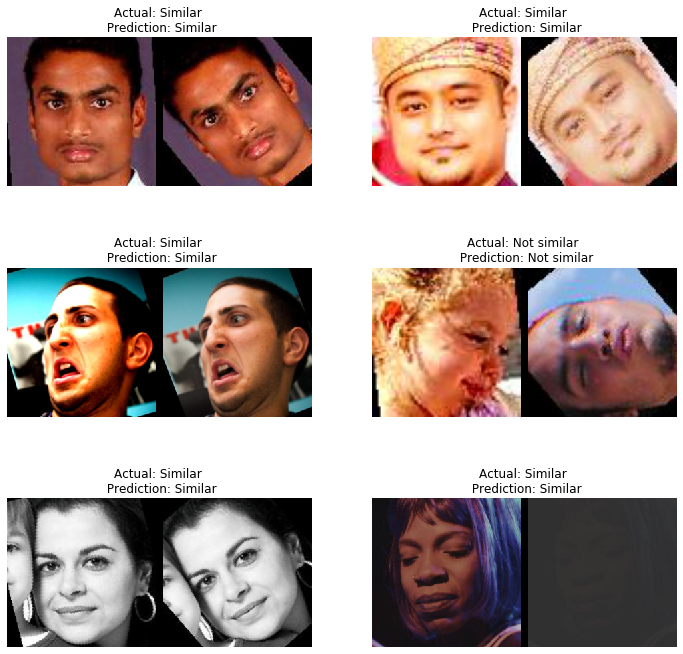

In [25]:
learn.show_results()

In [26]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    print(res)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

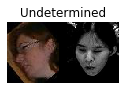

In [27]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

(tensor(0), tensor(0), tensor([0.7172, 0.2828]))


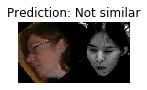

In [28]:
res = learn.siampredict(siamtest)

In [29]:
test_img_paths = get_image_files('data/test_images')
test_img_paths

(#10) [Path('data/test_images/b/4.jpg'),Path('data/test_images/b/1.jpg'),Path('data/test_images/b/6.jpg'),Path('data/test_images/b/10.jpg'),Path('data/test_images/b/8.jpg'),Path('data/test_images/h/3.jpg'),Path('data/test_images/h/7.jpg'),Path('data/test_images/h/2.jpg'),Path('data/test_images/h/5.jpg'),Path('data/test_images/h/9.jpg')]

In [30]:
def create_random_tests(filenames):
    file1 = random.choice(filenames)
    file2 = random.choice(filenames)
    same = True if str(file1) == str(file2) else False
    return PILImage.create(file1), PILImage.create(file2), same

In [31]:
learn.validate()

(#2) [0.16758444905281067,0.9373695254325867]

In [ ]:
correct = 0
for i in range(10):
    imgtest, imgval, same = create_random_tests(test_img_paths)
    siamtest = SiameseImage(imgval, imgtest)    
    res = learn.siampredict(siamtest)
    
print("correct: ", correct, " --> ", correct/30)